In [183]:
import Pkg
Pkg.add("PrettyTables")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
    Updating `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  [08abe8d2] + PrettyTables v2.3.1
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
Precompiling project...
  ✓ StaticArrays → StaticArraysChainRulesCoreExt
  ✓ BangBang → BangBangChainRulesCoreExt
  ✓ Distances → DistancesChainRulesCoreExt
  ✓ Roots
  ✓ MvNormalCDF
  ✓ AccessorsExtra → DistributionsExt
  ✓ LoopVectorization → ForwardDiffExt
  ✓ SciMLBase → SciMLBaseChainRulesCoreExt
  ✓ Roots → RootsForwardDiffExt
  ✓ Clustering
  ✓ DiffEqBase → DiffEqBaseChainRulesCoreExt
  ✓ WilliamsonTransforms
  ✓ FinanceCore
  ✓ DiffEqBase → DiffEqBaseDistributionsExt
  ✓ DiffEqNoiseProcess
  ✓ FinanceModels
  ✓ Copulas
  ✓ EconomicScenarioGenerators
  ✓ EconomicScenarioGenerators → FinanceModelsExt
  19 dependencies successfully precompiled in 57 seconds. 398 already precompiled.


In [1]:
using DataFrames, FredData, XLSX, SHA, Dates, CSV, TimeSeries, StatsBase, HiddenMarkovModels, Distributions, Plots, PrettyTables

In [2]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    sigma = rand(Uniform(0,0.25))
    means = rand(Uniform(-0.25,0.25))
    return Normal(means,sigma)
end

function train_hmm(data, n_scenarios = 2)

    function guess_distribution()
        sigma = rand(Uniform(0,0.25))
        means = rand(Uniform(-0.25,0.25))
        return Normal(means,sigma)
    end
    
    init_guess = guess_init(n_scenarios)
    guess_matrix = guess_tmatrix(n_scenarios)
    guess_dist = [guess_distribution() for s in 1:n_scenarios]
    hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
    return hmm_est, loglikelihood_evolution = baum_welch(hmm_guess, data);
end 

train_hmm (generic function with 2 methods)

In [3]:
function regime_summary(loglikehood,hmm_est, freq = 1)
        tm = transition_matrix(hmm_est)
        
   return DataFrame(Dict(
      "mu1" => mean(obs_distributions(hmm_est)[1]) * freq,
      "sig1" => std(obs_distributions(hmm_est)[1]) *  freq^0.5,
      "mu2" => mean(obs_distributions(hmm_est)[2]) * freq,
      "sig2" => std(obs_distributions(hmm_est)[2]) * freq^0.5,       
      "p11" =>  tm[1,1],
      "p21" =>  tm[2,1],
      "loglikehood" => last(loglikehood),
      "prob1" =>  tm[2,1]/(tm[1,2]+tm[2,1])
      
  )) 
  end

regime_summary (generic function with 2 methods)

In [4]:
function regime_summary_2(loglikehood,hmm_est, freq = 1)
    tm = transition_matrix(hmm_est),
    n_regimes = length(initialization(hmm_est))
    dict = Dict()
   
    return n_regimes
      
end


regime_summary_2 (generic function with 2 methods)

In [5]:
source_data = TimeArray(CSV.File("assets_data_03.24.csv", delim=';', dateformat="u dd, yyyy", decimal=','),timestamp=:Date)
ACWI_PLN = source_data.ACWI_Net .* source_data.USDPLN
source_data = merge(source_data,ACWI_PLN)
returns = log.(percentchange(source_data) .+ 1)

435×3 TimeArray{Union{Missing, Float64}, 2, Date, Matrix{Union{Missing, Float64}}} 1988-01-29 to 2024-03-29
┌────────────┬─────────────┬─────────────┬─────────────────┐
│            │ ACWI_Net    │ USDPLN      │ ACWI_Net_USDPLN │
├────────────┼─────────────┼─────────────┼─────────────────┤
│ 1988-01-29 │   0.0246253 │     missing │         missing │
│ 1988-02-29 │   0.0560778 │     missing │         missing │
│ 1988-03-31 │   0.0302388 │     missing │         missing │
│ 1988-04-29 │   0.0125024 │     missing │         missing │
│ 1988-05-31 │  -0.0201209 │     missing │         missing │
│ 1988-06-30 │ -0.00119203 │     missing │         missing │
│ 1988-07-29 │     0.01818 │     missing │         missing │
│ 1988-08-31 │  -0.0566908 │     missing │         missing │
│     ⋮      │      ⋮      │      ⋮      │        ⋮        │
│ 2023-09-29 │   -0.042229 │   0.0576333 │       0.0154043 │
│ 2023-10-31 │   -0.030529 │  -0.0361159 │       -0.066645 │
│ 2023-11-30 │   0.0882833 │  -0.05258

In [6]:
stats = summarystats.(eachcol(values(returns)))

stats = DataFrame([stats[1],stats[2],stats[3]])


Row,mean,sd,min,q25,median,q75,max,nobs,nmiss
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00622469,0.0443616,-0.220834,-0.0181497,0.0124942,0.0330787,0.116238,435,0
2,0.000397277,0.0371301,-0.094026,-0.0247304,-0.00190905,0.0234364,0.166496,435,120
3,0.00581535,0.0380711,-0.111985,-0.0159863,0.00790445,0.0323534,0.105947,435,120


In [7]:
stats[:,1] *12

3-element Vector{Float64}:
 0.07469630583902334
 0.0047673239504150075
 0.06978414857853404

In [8]:
stats[:,2] *12^0.5

3-element Vector{Float64}:
 0.15367294034595488
 0.12862229739242811
 0.13188217654652964

In [215]:
acwi_long = identity.(values(returns[:ACWI_Net]))
hmm_est, loglikehood = train_hmm(acwi_long,2)
println("ACWI long 2")
regime_summary(loglikehood,hmm_est,12)

ACWI long 2


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,774.685,0.160694,-0.011589,0.940202,0.0580528,0.492594,0.0873582,0.195717


In [10]:
acwi_long = identity.(values(returns[:ACWI_Net]))
hmm_est, loglikehood = train_hmm(acwi_long,4)
println("ACWI long 4")
regime_summary(loglikehood,hmm_est,12)

ACWI long 4


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,793.561,0.349085,0.900817,0.240889,0.261989,0.999997,0.0620138,0.0734084


In [11]:
acwi_98 = identity.(values(from(returns[:ACWI_Net],Date(1998,01,01))))
hmm_est, loglikehood = train_hmm(acwi_98,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,523.424,-1.73048,0.0799342,6.16222e-117,0.00833489,0.008266,0.0246313,0.154532


In [12]:
acwi_03 = identity.(values(from(returns[:ACWI_Net],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,428.253,0.0757608,0.0962134,0.0199772,0.983917,0.500992,0.154735,0.157882


In [257]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_USDPLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12), std: $(std(acwi_pln_98)*12^0.5)")
hmm_est, loglikehood = train_hmm(acwi_pln_98,2)
regime_summary(loglikehood,hmm_est,12)

mean 0.06978414857853404, std: 0.13188217654652964


Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,597.333,0.150326,-0.890542,0.942194,0.686865,0.922374,0.10644,0.0753485


In [207]:
acwi_pln_01 = identity.(values(from(returns[:ACWI_Net_USDPLN ],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_01,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,543.406,0.14382,-0.149782,0.958614,0.115496,0.736196,0.0911427,0.180197


In [209]:
acwi_pln_03 = identity.(values(from(returns[:ACWI_Net_USDPLN],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(acwi_pln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,508.416,0.143988,-0.0951979,0.954914,0.162322,0.782622,0.0905744,0.178228


In [218]:
usdpln_03 = identity.(values(from(returns[:USDPLN ],Date(2003,01,01))))
hmm_est, loglikehood = train_hmm(usdpln_03,2)
regime_summary(loglikehood,hmm_est,12)

Row,loglikehood,mu1,mu2,p11,p21,prob1,sig1,sig2
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,484.829,0.117699,-0.0247202,0.968312,0.00738609,0.189027,0.210461,0.106832


In [61]:
function guess_init(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios)
    return regimes_probs/sum(regimes_probs)
end

function guess_tmatrix(n_scenarios)
    regimes_probs = rand(1:100,n_scenarios,n_scenarios)
    return regimes_probs ./ sum(regimes_probs,dims=2)
end

function guess_distribution()
    corr = Matrix(1.0I,2,2)
    sigma = [rand(Uniform(0,0.25)),rand(Uniform(0,0.035))]
    means = [rand(Uniform(-0.5,0.5)),rand(Uniform(-0.01,0.12))]
    cov = cor2cov(corr,sigma)
    return MvNormal(means,cov)
end

using LinearAlgebra

In [62]:
acwi_and_pln = identity.(values(from(returns[:ACWI_Net_USDPLN, :USDPLN],Date(2001,01,01))))
n_scenarios = 2


init_guess = guess_init(n_scenarios)
guess_matrix = guess_tmatrix(n_scenarios)
guess_dist = [guess_distribution() for s in 1:n_scenarios]
hmm_guess = HMM(init_guess, guess_matrix, guess_dist);
println(hmm_guess)
hmm_est_concat, _ = baum_welch(hmm_guess, eachrow(acwi_and_pln));

Hidden Markov Model with:
 - initialization: [0.8181818181818182, 0.18181818181818182]
 - transition matrix: [0.5522388059701493 0.44776119402985076; 0.7307692307692307 0.2692307692307692]
 - observation distributions: [FullNormal(
dim: 2
μ: [0.1308937526402697, 0.04843983454763298]
Σ: [0.04332492078775014 0.0; 0.0 0.0011088398460050177]
)
, FullNormal(
dim: 2
μ: [0.3396007084466849, 0.07997087586657387]
Σ: [0.006564571772299798 0.0; 0.0 0.0005179311269944135]
)
]


In [63]:
dist1 = obs_distributions(hmm_est_concat)[1]
dist2 = obs_distributions(hmm_est_concat)[2]

mean1 = mean(dist1) .* 12
mean2 = mean(dist2) .* 12

std1 = sqrt.(var(dist1)) .* 12^0.5
std2 = sqrt.(var(dist2)) .* 12^0.5
display("means")
display([mean1 mean2])
display("std")
display([std1 std2])
display("corr")
cor1 = cor(dist1)
display(cor1)
cor2 = cor(dist2)
display(cor2)


"means"

2×2 Matrix{Float64}:
  0.0544536  0.462443
 -0.024655   1.6084

"std"

2×2 Matrix{Float64}:
 0.128809  0.0829455
 0.118234  0.0719586

"corr"

2×2 Matrix{Float64}:
 1.0      0.20327
 0.20327  1.0

2×2 Matrix{Float64}:
 1.0       0.992158
 0.992158  1.0

In [64]:
acwi_short = identity.(values(from(returns[:ACWI_Net],Date(2001,01,01))))
hmm_est, loglikehood = train_hmm(acwi_short,2)
obs_distributions(hmm_est)

2-element Vector{Normal{Float64}}:
 Normal{Float64}(μ=-0.003135889718622911, σ=0.059348999106004954)
 Normal{Float64}(μ=0.013892046713966598, σ=0.023421051436694464)

In [65]:
acwi_short = identity.(from(returns[:ACWI_Net],Date(2001,01,01)))
hmm_est, loglikehood = train_hmm(values(acwi_short),2)
HMM(initialization(hmm_est), transition_matrix(hmm_est), obs_distributions(hmm_est))
states,_ = viterbi(hmm_est,values(acwi_short))
states = Float64.(states)

279-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [66]:
acwi_states = merge(acwi_short,identity.(from((returns[:USDPLN]),Date(1998,01,01))),TimeArray(timestamp(acwi_short),states))
CSV.write("states",acwi_states)


"states"

In [67]:
first_regime = acwi_states[findwhen(acwi_states[:A] .== 1.0)]
second_regime = acwi_states[findwhen(acwi_states[:A] .== 2.0)]

println("First usd pln")
println(mean(values(first_regime[:USDPLN]))*12)
println(std(values(first_regime[:USDPLN]))*12^0.5)
println(cor(values(first_regime[:USDPLN]),values(first_regime[:ACWI_Net ])))

println("Second usd pln")
println(mean(values(second_regime[:USDPLN]))*12)
println(std(values(second_regime[:USDPLN]))*12^0.5)
println(cor(values(second_regime[:USDPLN]),values(second_regime[:ACWI_Net])))

First usd pln
0.023239055189205573
0.14920806835446282
-0.6632535242025056
Second usd pln
-0.029791512628015195
0.104989023291778
-0.552543385302522


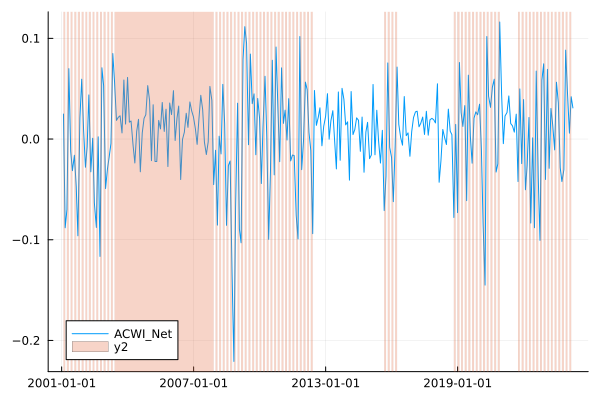

In [47]:
plot(acwi_states[:ACWI_Net ])
vspan!(findwhen(acwi_states[:A] .== 2.0),alpha = 0.3)

In [68]:
using ScenTrees, SDDP

In [260]:
acwi_pln_98 = identity.(values(from(returns[:ACWI_Net_USDPLN ],Date(1998,01,01))))
println("mean $(mean(acwi_pln_98)*12)")
println("std $(std(acwi_pln_98)*12^0.5)")

mean 0.06978414857853404
std 0.13188217654652964


In [259]:
n_steps = 15
n_scenarios = 5000
simulations = rand(Normal(0.07,0.132),(n_scenarios,n_steps)) 

simulation_perc = zeros(5,n_steps)
for t in 1:n_steps
    simulation_perc[:,t] = quantile(simulations[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end
pretty_table(simulation_perc, backend = Val(:html),header=1:n_steps, row_labels=[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.144558,-0.144639,-0.147561,-0.151812,-0.139714,-0.149499,-0.146063,-0.150085,-0.149162,-0.14508,-0.142864,-0.145705,-0.144129,-0.145972,-0.149366
0.25,-0.0176903,-0.0144354,-0.0153888,-0.021521,-0.0190117,-0.0180342,-0.0184951,-0.0200985,-0.0210126,-0.014656,-0.0186906,-0.0219147,-0.0196753,-0.0220187,-0.0206154
0.5,0.0683905,0.0719288,0.0702441,0.0682586,0.0703308,0.0703877,0.0670221,0.0717593,0.0699317,0.0747688,0.0707361,0.0684065,0.0695016,0.0665451,0.0700061
0.75,0.158637,0.157807,0.158248,0.155999,0.160222,0.159694,0.15667,0.163138,0.15664,0.165029,0.158897,0.160337,0.157341,0.157732,0.156588
0.95,0.28228,0.280641,0.287811,0.284162,0.282966,0.29054,0.288766,0.285445,0.287677,0.293253,0.285489,0.291552,0.291063,0.284832,0.28538


In [71]:
hmm = HMM([1,0.],[0.85 0.15; 0.41 0.59],[Normal(0.0986,0.1041),Normal(0.0291,0.1435)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulation_perc = zeros(5,n_steps)
for t in 1:n_steps
    simulation_perc[:,t] = quantile(simulations[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

pretty_table(simulation_perc, backend = Val(:html),header=1:n_steps, row_labels=[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.070967,-0.101973,-0.115833,-0.114282,-0.121222,-0.114199,-0.119596,-0.122726,-0.127869,-0.123267,-0.128722,-0.122888,-0.129141,-0.117342,-0.117214
0.25,0.0319956,0.0193423,0.00787677,0.00502406,0.00463754,0.0125389,0.00894117,0.00438546,0.00651136,0.002006,0.0054015,0.00319812,0.00250527,0.00550927,0.0086329
0.5,0.0996033,0.0916309,0.086653,0.0806974,0.0856075,0.0871035,0.0861194,0.0843567,0.085158,0.0790176,0.0828562,0.0832519,0.0824759,0.0835347,0.0879838
0.75,0.170476,0.167563,0.163025,0.161912,0.158848,0.163773,0.15989,0.159216,0.161972,0.157069,0.156774,0.160753,0.160576,0.163241,0.161562
0.95,0.271522,0.271298,0.269238,0.269619,0.268147,0.267597,0.270377,0.268193,0.269267,0.271636,0.272203,0.270276,0.266673,0.269103,0.269544


In [72]:
simulations

5000×15 Matrix{Float64}:
  0.0971247    0.0421698    0.151975    …  -0.0290774    0.314199
  0.139814    -0.0890352    0.00744693      0.125441    -0.00585347
 -0.00119074   0.0954142    0.0978511       0.0557905    0.0129225
  0.0736218    0.133269    -0.171557        0.200899    -0.106515
  0.0102148    0.120549     0.2789          0.0634084    0.161851
  0.203395     0.0112736   -0.00543814  …   0.141653     0.108331
  0.108144     0.269388     0.0233665       0.00585048   0.0291277
  0.146894     0.289424     0.0872341      -0.053285    -0.0348326
  0.140711    -0.0621141    0.0921835       0.206979     0.131803
  0.0506435    0.142137     0.0290792       0.135706     0.160173
  ⋮                                     ⋱               
 -0.0193071    0.0393086    0.404022        0.0237544   -0.200138
  0.0601303    0.105776     0.0286962       0.0984622    0.139374
 -0.0983173    0.146266    -0.103684        0.140773     0.166555
  0.191177     0.0225319   -0.026731        0.176667   

In [73]:
scenarios= reshape(simulations,(5000*15,1))
vec(scenarios)

75000-element Vector{Float64}:
  0.09712471911576885
  0.13981368435688074
 -0.001190741597311737
  0.07362175048839445
  0.010214754515894889
  0.20339477149176605
  0.1081436633188563
  0.14689396604065774
  0.14071123057043627
  0.05064349092239579
  ⋮
 -0.20013835988068435
  0.13937377864380543
  0.16655526910045557
  0.030229512736158315
 -0.1254539934987476
  0.09422649263588041
  0.05158351492252663
  0.1626586171631961
  0.10371861617555228

In [74]:
train_hmm(vec(scenarios),4)

(Hidden Markov Model with:
 - initialization: [3.617680801230623e-18, 0.9999999999996039, 1.3625618589261053e-32, 3.961105100360059e-13]
 - transition matrix: [0.12533717189751437 0.182286500257122 0.17491419983162246 0.5174621280137411; 0.18553632561590158 0.33141491554217173 0.13960017857544577 0.34344858026648095; 0.2027992465598912 0.40313120344988285 0.1730524162635041 0.2210171337267218; 0.28735742881682835 0.06996716430615814 0.12653282518969927 0.5161425816873143]
 - observation distributions: [Normal{Float64}(μ=0.03586652089225134, σ=0.10971029620759858), Normal{Float64}(μ=0.08564917674491278, σ=0.08978582991664556), Normal{Float64}(μ=0.02053067356207088, σ=0.1457822936014557), Normal{Float64}(μ=0.12566912411459552, σ=0.10314100724705844)], [22461.98633999863, 54172.18885554846, 54256.13787622988, 54279.96440674605, 54292.73651170528, 54302.24421244388, 54310.03774335429, 54316.61551498455, 54322.24303907501, 54327.10251102335  …  54376.296793291556, 54376.386047788605, 54376.

In [316]:
function simulator()
    scenarios = rand(Normal(0.07/12,0.132/12^0.5),180)
    return annualise(scenarios,12)
end

graph = SDDP.MarkovianGraph(simulator; budget = [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4], scenarios = 10_000);
graph


Root
 (0, 0.0)
Nodes
 (1, -0.06930537835366055)
 (1, 0.01692181915913998)
 (1, 0.13213120911395304)
 (1, 0.3695427148192531)
 (2, -0.023882331479501764)
 (2, 0.12493761647643647)
 (2, 0.15201132371817705)
 (2, 0.3779868532449914)
 (3, -0.047284404712915465)
 (3, 0.016951037270611643)
 (3, 0.13345788757664417)
 (3, 0.37128049746403546)
 (4, -0.024312044743482284)
 (4, 0.07074361532272913)
 (4, 0.1390412718840584)
 (4, 0.37817523567610745)
 (5, -0.06329822849469638)
 (5, 0.01605492301014174)
 (5, 0.13622529254260152)
 (5, 0.36519700364642566)
 (6, -0.024475336323990574)
 (6, 0.07699307017777608)
 (6, 0.13768625184533026)
 (6, 0.37207993677833284)
 (7, -0.02176804258629718)
 (7, 0.12666071949970084)
 (7, 0.26391024580814343)
 (7, 0.37226496376191687)
 (8, -0.028235600889892413)
 (8, 0.0162121704210417)
 (8, 0.13317334013318646)
 (8, 0.3752562576122345)
 (9, -0.022825980158952985)
 (9, 0.0713636208535981)
 (9, 0.13898977508322305)
 (9, 0.3713202248090851)
 (10, -0.09212059492544818)
 (10, 

In [76]:
function regime_sampler()
    hmm = HMM([1.,0.],[0.85 0.15; 0.41 0.59],[Normal(0.0986,0.1041),Normal(0.0291,0.1435)])
    rand(hmm,5)[2]
end

regime_sampler()

5-element Vector{Float64}:
  0.1928463679402744
  0.03229624793466417
 -0.10796928391622129
  0.30571989159560303
  0.11381949116944962

In [77]:
graph = SDDP.MarkovianGraph(regime_sampler; budget = [8,8,8,8,8], scenarios = 10_000);
graph

Root
 (0, 0.0)
Nodes
 (1, -0.02010778400020491)
 (1, 0.0388473842709886)
 (1, 0.07966480656428465)
 (1, 0.11609210498602618)
 (1, 0.12034886965747844)
 (1, 0.15494512084830162)
 (1, 0.205955802370894)
 (1, 0.3347912436275562)
 (2, -0.05223219346089109)
 (2, -0.02809583978081091)
 (2, 0.026650155175745482)
 (2, 0.07152164579758541)
 (2, 0.10909938264922635)
 (2, 0.149035086840667)
 (2, 0.20438521903554527)
 (2, 0.3419904894935666)
 (3, -0.11837246708251938)
 (3, -0.03889711000892915)
 (3, 0.022413710267963485)
 (3, 0.06562763878702375)
 (3, 0.10731141783222935)
 (3, 0.14970168165551634)
 (3, 0.20546524531363758)
 (3, 0.3468900903211874)
 (4, -0.05781453515301668)
 (4, -0.003446373334244774)
 (4, 0.019550125595836437)
 (4, 0.06381037548876665)
 (4, 0.10489662039007026)
 (4, 0.1481025464618154)
 (4, 0.2034454372052272)
 (4, 0.34656789368366914)
 (5, -0.053587677107252187)
 (5, 0.021881315117594044)
 (5, 0.06560910993766574)
 (5, 0.10559425484720474)
 (5, 0.14843196514596282)
 (5, 0.201661

simulator()

In [78]:
function simulator()
    rand(Normal(0.07,0.132),4,1)
end

simulator()

4×1 Matrix{Float64}:
  0.20167434654876154
  0.10854789930814064
  0.05549332649600035
 -0.13616705152940506

In [306]:
sims = [0.06 0.13 -0.23 0.3 -0.05 0.15; 0.15 -0.23 0.06 0.13 0.3 -0.05; -0.05 0.3 -0.23 0.15 0.06 0.13]

function annualise(scenarios:: Matrix, shift=2)
   
    periods = floor.(Int, size(scenarios)[2]/shift)
    result = zeros(size(scenarios)[1],periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[:,p] .= sum(scenarios[:,start:en],dims=2)
    end 
    return result
   
end

annualise(sims,2)



3×3 Matrix{Float64}:
  0.19   0.07  0.1
 -0.08   0.19  0.25
  0.25  -0.08  0.19

In [305]:
function annualise(scenarios:: Vector, shift=2)
   
    periods = floor.(Int, size(scenarios)[1]/shift)
    result = zeros(periods)

    for p in 1:periods
        start = (p-1)*shift+1
        en = p*shift
        result[p] = sum(scenarios[start:en])
    end  
    return result
   
end

annualise(sims[1,:],2)

3-element Vector{Float64}:
 0.19
 0.06999999999999998
 0.09999999999999999

In [307]:
years = 15
n_steps = years*12
hmm = HMM([1.,0],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])
simulations = zeros(n_scenarios,n_steps)
for s in 1:n_scenarios
    simulations[s,:] .= rand(hmm,n_steps)[2]
end

simulations_ann = annualise(simulations,12)
simulation_perc = zeros(5,years)
for t in 1:years
    simulation_perc[:,t] = quantile(simulations_ann[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

pretty_table(simulation_perc, backend = Val(:html),header=1:years, row_labels=[0.05, 0.25, 0.5, 0.75, 0.95])

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0.05,-0.148547,-0.229833,-0.23467,-0.232931,-0.24816,-0.248022,-0.237315,-0.237544,-0.235886,-0.246764,-0.235199,-0.240152,-0.240689,-0.238728,-0.24135
0.25,0.0363488,-0.0141937,-0.0157099,-0.0198682,-0.0218523,-0.0211414,-0.0218861,-0.024083,-0.0168556,-0.0235281,-0.0190564,-0.0167993,-0.0216902,-0.0190216,-0.0250417
0.5,0.123094,0.101995,0.0957285,0.0918878,0.0940265,0.0914838,0.093815,0.0905501,0.0985673,0.0914433,0.0932762,0.0926962,0.0950829,0.0974482,0.0949975
0.75,0.204246,0.18811,0.182971,0.179593,0.182943,0.184268,0.182819,0.183589,0.185528,0.183495,0.18101,0.184076,0.181371,0.185365,0.184907
0.95,0.304819,0.295064,0.295557,0.29575,0.295278,0.298138,0.29958,0.295604,0.29407,0.291649,0.290488,0.295479,0.292195,0.297406,0.301288


In [368]:
function regime_sampler_ann()    
    hmm = HMM([1,0.],[0.95 0.05; 0.124529 0.875471],[Normal(0.0134,0.0277),Normal(-0.0134,0.0515)])    
    return annualise(rand(hmm,15*12)[2], 12)
end

regime_sampler_ann()


15-element Vector{Float64}:
  0.04525201344676043
 -0.21233559438507693
 -0.22478976076768106
  0.13853411510313735
  0.06330881828197796
  0.13577947477437208
  0.27116517238365073
  0.16751017362030104
  0.2506784110332879
  0.3001528308056507
  0.14887642115022914
  0.0005535039637369586
  0.047959519677646285
  0.26482192257682513
  0.13933062596120613

In [373]:
graph = SDDP.MarkovianGraph(regime_sampler_ann; budget = fill(12,15), scenarios = 10_000);
graph

Root
 (0, 0.0)
Nodes
 (1, -0.0951957327577383)
 (1, 0.00018928202319836324)
 (1, 0.04664615432084805)
 (1, 0.0806077299898187)
 (1, 0.10990595849621487)
 (1, 0.11550574829718507)
 (1, 0.13579400326836288)
 (1, 0.16220050210849918)
 (1, 0.19148686028389592)
 (1, 0.22268885556309276)
 (1, 0.2648813889414114)
 (1, 0.3705104169095029)
 (2, -0.17182555447340625)
 (2, -0.06274398784251355)
 (2, -0.0031267017533659768)
 (2, 0.03161990610538197)
 (2, 0.04102006603877585)
 (2, 0.07863139542445641)
 (2, 0.1115822671252475)
 (2, 0.1426155412279371)
 (2, 0.17409773242600893)
 (2, 0.20856093863098668)
 (2, 0.25397398969932716)
 (2, 0.374258162261673)
 (3, -0.30989222002058675)
 (3, -0.16465976458673778)
 (3, -0.0703243024133426)
 (3, -0.008627528711481945)
 (3, 0.034389192907128024)
 (3, 0.0712665908170091)
 (3, 0.10567502450639198)
 (3, 0.13820292908958998)
 (3, 0.1721206562004369)
 (3, 0.20883190928929565)
 (3, 0.25331225445773004)
 (3, 0.37128773637534146)
 (4, -0.1883279444368803)
 (4, -0.07764

In [337]:
running_maximum1D()

4×1 Matrix{Float64}:
 0.0
 0.7177077109955162
 2.865154141605181
 3.236752116964687

In [338]:
lattice_approximation(fill(4,15),regime_sampler,100000,2,1);

BoundsError: BoundsError: attempt to access Tuple{Int64} at index [2]

In [202]:
Base.LinRange(-3.5,3.5,8)

8-element LinRange{Float64, Int64}:
 -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5